# preparation

In [1]:
%pip install gdown &> /dev/null

## globals

In [2]:
SEED = 42069

RELATIVE_FILE_NAME = "stock_data_relative.pkl"
# RELATIVE_URL = "https://drive.google.com/file/d/1-dDNv2DE180XhLM-6tRycqI0QZiQoeEE/view?usp=share_link"
RELATIVE_URL = "https://drive.google.com/file/d/1FwAzqNT9bS3zJcwD_g1HRkqJi9OdrUHb/view?usp=share_link"

RAW_FILE_NAME = "stock_data_raw.pkl"
# RAW_URL = "https://drive.google.com/file/d/1LB6m5EhkAD596_V5LukEm1S8ItKgus6R/view?usp=share_link"
RAW_URL = "https://drive.google.com/file/d/1Ob64n9yj9-xI1m7NK-mvc-r29NqaSQBv/view?usp=share_link"

In [3]:
TICKERS = [
    "CASH",         # Cash *

    # USA
    "^GSPC",        # S&P 500 *
    "^DJI",         # Dow Jones *
    "^IXIC",        # NASDAQ *
    "^RUT",         # Russel 2000 *
    "^VIX",         # Volatility index *

    "DX-Y.NYB",     # USD index

    "^FVX",         # Treasury Yield 5 Years
    "^TNX",         # Treasury Yield 10 Years *
    
    # Asia
    "^HSI",         # heng seng *
    "399001.SZ",    # Shen zhen
    "000001.SS",    # Shanghai *
    "^N225",        # Japan *
    "^STI",         # Singapore *
    "^BSESN",       # Bombay
    "^TWII",        # Taiwan *
    "^JKSE",        # Indonesia
    
    # Europe
    "^FTSE",        # London *
    "^N100",        # Europe *
    "^FCHI",        # France *
    "^GDAXI",       # Germany *
    
    # America
    "^MXX",         # IPC Mexico
    "^BVSP",        # Brazil
    
    # Other
    "^AORD",        # Australia

    # Futures
    "GC=F",         # Gold
    "SI=F",         # Silver
    "HG=F",         # Copper
    "CL=F",         # Crude Oil
    "NG=F",         # Natural Gas    
    "KE=F",         # Wheat
    "CT=F",         # Cotton
]

TO_TRADE = [
    "CASH",         # Cash *

    "^GSPC",        # S&P 500 *
    "^DJI",         # Dow Jones *
    "^IXIC",        # NASDAQ *
    "^RUT",         # Russel 2000 *
    "^VIX",         # Volatility index *
    "^TNX",         # Treasury Yield 10 Years *
    "^HSI",         # heng seng *
    "000001.SS",    # Shanghai *
    "^N225",        # Japan *
    "^STI",         # Singapore *
    "^TWII",        # Taiwan *
    "^FTSE",        # London *
    "^N100",        # Europe *
    "^FCHI",        # France *
    "^GDAXI",       # Germany *
]

In [4]:
import torch
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## set seed

In [5]:
import torch
import numpy as np

def same_seed(seed): 
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

In [6]:
same_seed(SEED)

# process data

## load dataset

In [7]:
import os
import gdown
import pandas as pd

# Download data
def get_data(filename, url):
    if os.path.isfile(filename):
        print(f'{filename} already exists')
    else:
        gdown.download(url=url, output=filename, quiet=False, fuzzy=True)

In [8]:
get_data(RAW_FILE_NAME, RAW_URL)
# raw_stock_df = pd.read_pickle(RAW_FILE_NAME)
raw_stock_df = pd.read_csv(RAW_FILE_NAME)

get_data(RELATIVE_FILE_NAME, RELATIVE_URL)
# relative_stock_df = pd.read_pickle(RELATIVE_FILE_NAME)
relative_stock_df = pd.read_csv(RELATIVE_FILE_NAME)


# stock_df = pd.read_csv(FILE_NAME)

Downloading...
From: https://drive.google.com/uc?id=1Ob64n9yj9-xI1m7NK-mvc-r29NqaSQBv
To: /content/stock_data_raw.pkl
100%|██████████| 25.9M/25.9M [00:00<00:00, 62.5MB/s]
Downloading...
From: https://drive.google.com/uc?id=1FwAzqNT9bS3zJcwD_g1HRkqJi9OdrUHb
To: /content/stock_data_relative.pkl
100%|██████████| 17.3M/17.3M [00:00<00:00, 35.7MB/s]


In [9]:
# split train & test data
from datetime import datetime

str_date_list = raw_stock_df["Unnamed: 0"]
for index, str_date in enumerate(str_date_list):
    if (datetime.strptime(str_date, '%Y-%m-%d').year == 2015):
        print(index)
        split_index = index
        break
train_raw_stock_df = raw_stock_df[ : split_index]
test_raw_stock_df = raw_stock_df[split_index : ]

train_relative_stock_df = relative_stock_df[ : split_index]
test_relative_stock_df = relative_stock_df[split_index : ]

7303


## process dataset

In [10]:
def transform_dataframe(df):
    stock_dict = {}
    columns = ("Open", "Close", "High", "Low")
    tickers = set(map(lambda col: col.split(":")[1], df.columns))
    for ticker in tickers:
        ticker_columns = map(lambda col: f"{col}:{ticker}", columns)
        # drop the ticker in column name
        stock_dict[ticker] = df[ticker_columns].reset_index().rename(columns={"index": "Date"})

    return stock_dict

In [11]:
def select_stocks(df, tickers):
    np_arrays = []
    for ticker in tickers:
        columns = []
        for col in ["Open", "Close", "High", "Low"]:
            columns.append(f'{col}:{ticker}')
        np_arrays.append(df[columns].values)
    ret = np.stack(np_arrays).astype(np.float32)
    return ret


# environment

In [12]:
import random
from collections import namedtuple
from typing import List

EnvironmentConfig = namedtuple(
    "EnvironmentConfig",
    (
        "window_size",
        "episode_duration",
        "trading_cost",
        "assets",
        "to_trade",
        "get_baseline_action",
        "state_scaling",
    )
)

class Environment:
    def __init__(self, dfs, config: EnvironmentConfig, test=False):
        raw_df, relative_df = dfs
        
        self.config = config
        self.data = select_stocks(raw_df, config.assets)
        self.y = select_stocks(relative_df, config.to_trade)
        self.window_size = config.window_size
        self.episode_duration = config.episode_duration
        
        self.now_episode_head = 0
        self.now_episode_len = 0

        self.state_size = len(self.data)
        self.action_size = len(self.y)

        self.get_baseline_action = config.get_baseline_action

        self.last_baseline_action = self.get_baseline_action(self.action_size)

        self.assets = config.assets
        self.to_trade = config.to_trade
        self.trading_cost = config.trading_cost
        self.test = test

    def get_first_action(self):
        return np.array([[1] + [0] * (self.action_size - 1)], dtype=np.float32)

    def normalize_state(self, state):
        normalized_state = np.stack([ a / a[-1,1] for a in state ])
        normalized_state = (normalized_state - 1) * self.config.state_scaling
        return normalized_state

    def step(self, action): # -> state, reward, done
        reward, bonus_reward = self.calculate_reward(action)
        
        current_y = self.y[:, self.now_episode_head - 1, 1]
        self.last_action = (current_y * action.squeeze()) / (np.dot(current_y, action.squeeze())).reshape(1, -1)

        self.now_episode_head += 1
        self.now_episode_len += 1
        state = self.data[:, self.now_episode_head - self.window_size : self.now_episode_head, :]
        state = self.normalize_state(state)
        state = torch.tensor(state).to(DEVICE)

        done = (self.now_episode_len == self.episode_duration)

        return (state, self.last_action), reward, bonus_reward, done

    def reset(self): # -> state
        if self.test:
            self.now_episode_head = self.window_size
        else:
            self.now_episode_head = random.randint(self.window_size, self.data.shape[1] - self.episode_duration - 1)
        self.now_episode_len = 0

        state = self.data[:, self.now_episode_head-self.window_size : self.now_episode_head, :]
        state = self.normalize_state(state)
        state = torch.tensor(state).to(DEVICE)

        self.last_action = self.get_first_action()

        return (state, self.last_action)

    def calculate_growth(self, action, last_action):
        # 0     <1>    2     3
        # open, close, high, low --------------------v
        # current_y = self.y[:, self.now_episode_head - 1, 1]
        next_y = self.y[:, self.now_episode_head, 1]
        current_w = action.squeeze()

        last_w = last_action.squeeze()
        # before_txn_w = (current_y * last_w) / (np.dot(current_y, last_w))

        # ut = self.trading_cost * (np.abs(current_w[1:] - before_txn_w[1:]).sum())
        ut = self.trading_cost * (np.abs(current_w[1:] - last_w[1:]).sum())

        growth = (1 - ut) * np.dot(next_y, current_w)

        return growth

    def calculate_reward(self, action):
        reward = np.log(self.calculate_growth(action, self.last_action))
        reward = reward.item() #
        bonus_reward = max(0, reward - self.calculate_baseline_reward())
        if bonus_reward != 0:
            if self.now_episode_len % 100 == 0:
                print(f"reward: {reward}, bonus_reward: {bonus_reward}")
#         return reward.item()
        return reward, bonus_reward

    def calculate_baseline_reward(self):
        action = self.get_baseline_action(self.action_size)
        reward = np.log(self.calculate_growth(action, self.last_baseline_action))
        self.last_baseline_action = action
        return reward.item()


# networks

## grader

In [13]:
from collections import namedtuple
import torch.nn as nn

AssetGraderConfig = namedtuple(
    "AssetGraderConfig",
    (
        "state_size",
        "action_size",
        "hidden_size",
        "gru_layers",
        "encoder_layers",
    )
)

class AssetGrader(nn.Module):
    def __init__(self, config: AssetGraderConfig):
        super(AssetGrader, self).__init__()
        self.config = config

        self.grader = nn.GRU(
            input_size=4, # open. close, high, low
            hidden_size=config.hidden_size,
            num_layers=config.gru_layers,
            batch_first=True
        )

        encoder_layer = nn.TransformerEncoderLayer(
            d_model=config.hidden_size,
            nhead=config.hidden_size//2,
            dim_feedforward=32,
            batch_first=True
        )
        self.encoder =  nn.TransformerEncoder(
            encoder_layer,
            num_layers=config.encoder_layers,
        )

        self.fc1 = nn.Sequential(
            nn.ReLU(),
            nn.Linear(config.hidden_size, config.hidden_size),
            nn.ReLU(),
            nn.Linear(config.hidden_size, config.hidden_size * 2),
            nn.ReLU(),
            nn.Linear(config.hidden_size * 2, config.hidden_size),
            nn.ReLU(),
            nn.Linear(config.hidden_size, config.hidden_size // 2),
            nn.ReLU(),
            nn.Linear(config.hidden_size // 2, 1),
        )

        self.fc2 = nn.Sequential(
            nn.BatchNorm1d(config.state_size),
            nn.ReLU(),
            nn.Linear(config.state_size, config.state_size),
            nn.BatchNorm1d(config.state_size),
            nn.ReLU(),
            nn.Linear(config.state_size, config.action_size),
            nn.BatchNorm1d(config.action_size),
            nn.ReLU(),
            nn.Linear(config.action_size, config.action_size),
        )

    def forward(self, x):
        # for each asset, calculate its evaluation

        if not torch.is_tensor(x):
            x = torch.tensor(x)
        
        assert x.shape[0] % self.config.state_size == 0

        x = x.to(DEVICE)

        # (batch_size, state_size) * window_size * 4 -> (batch_size, state_size) * window_size * hidden_size
        h0 = torch.zeros(self.config.gru_layers, x.size(0), self.config.hidden_size).requires_grad_().to(DEVICE)
        gru_out, h0 = self.grader(x, h0.detach())
        
        # (batch_size, state_size) * window_size * hidden_size -> (batch_size, state_size) * hidden_size
        embeddings = gru_out[:, -1, :]

        # (batch_size, state_size) * hidden_size -> batch_size * state_size * hidden_size
        embeddings = embeddings.reshape(
            (
                -1,
                self.config.state_size,
                self.config.hidden_size,
            )
        )

        # batch_size * state_size * hidden_size -> batch_size * state_size * hidden_size
        grade = self.encoder(embeddings)

        # batch_size * state_size * hidden_size -> batch_size * state_size * 1
        grade = self.fc1(grade)

        # batch_size * state_size * 1 -> batch_size * state_size
        grade = grade.reshape(-1, self.config.state_size)

        # batch_size * state_size -> batch_size * action_size
        grade = self.fc2(grade)

        return grade

In [14]:
from collections import namedtuple
import torch.nn as nn

class SingleAssetGrader(nn.Module):
    def __init__(self, config: AssetGraderConfig):
        super(SingleAssetGrader, self).__init__()
        self.config = config

        self.grader = nn.GRU(
            input_size=4, # open. close, high, low
            hidden_size=config.hidden_size,
            num_layers=config.gru_layers,
            batch_first=True
        )

        self.fc1 = nn.Sequential(
            nn.ReLU(),
            nn.Linear(config.hidden_size, 1),
        )

    def forward(self, x):
        # for each asset, calculate its evaluation

        if not torch.is_tensor(x):
            x = torch.tensor(x)
        
        assert x.shape[0] % self.config.state_size == 0

        x = x.to(DEVICE)

        # (batch_size, state_size) * window_size * 4 -> (batch_size, state_size) * window_size * hidden_size
        h0 = torch.zeros(self.config.gru_layers, x.size(0), self.config.hidden_size).requires_grad_().to(DEVICE)
        gru_out, h0 = self.grader(x, h0.detach())
        
        # (batch_size, state_size) * window_size * hidden_size -> (batch_size, state_size) * hidden_size
        embeddings = gru_out[:, -1, :]

        # batch_size * state_size * hidden_size -> batch_size * state_size * 1
        grade = self.fc1(embeddings)

        # batch_size * state_size * 1 -> batch_size * state_size
        grade = grade.reshape(-1, self.config.state_size)

        return grade

## actor

In [15]:
import torch.nn as nn

class GRUActor(nn.Module):
    def __init__(self, config: AssetGraderConfig):
        super(GRUActor, self).__init__()
        self.config = config

#         self.grader = AssetGrader(config)
        self.grader = SingleAssetGrader(config)

        self.fc = nn.Sequential(
            nn.BatchNorm1d(config.action_size * 2),
            nn.ReLU(),
            nn.Linear(config.action_size * 2, config.action_size * 2),
    
            nn.BatchNorm1d(config.action_size * 2),
            nn.ReLU(),
            nn.Linear(config.action_size * 2, config.action_size),
        
            nn.BatchNorm1d(config.action_size),
            nn.ReLU(),
            nn.Linear(config.action_size, config.action_size),
        )
        
        self.softmax = nn.Softmax(1)

    def forward(self, state):
        # for each asset, calculate its evaluation
        x, w_0 = state

        if not torch.is_tensor(x):
            x = torch.tensor(x)
        if not torch.is_tensor(w_0):
            w_0 = torch.tensor(w_0)

        assert x.shape[0] % self.config.state_size == 0
        assert w_0.shape[-1] == self.config.action_size

        x = x.to(DEVICE)
        w_0 = w_0.to(DEVICE)

        grade = self.grader(x)

        # batch_size * state_size -> batch_size * (2 * action_size)
#         out = torch.cat((grade, w_0), 1)
        
#         # batch_size * (2 * action_size) -> batch_size * action_size
#         out = self.fc(out)

#         out = self.softmax(out)
        out = self.softmax(grade)

        return out

    def batched_forward(self, states):
        batch_x, batch_w_0 = list(zip(*states))

        if torch.is_tensor(batch_x[0]):
            batch_x = torch.cat(batch_x)
        elif isinstance(batch_x[0], np.ndarray):
            batch_x = np.concatenate(batch_x)

        if torch.is_tensor(batch_w_0[0]):
            batch_w_0 = torch.cat(batch_w_0)
        elif isinstance(batch_w_0[0], np.ndarray):
            batch_w_0 = np.concatenate(batch_w_0)

        return self.forward((batch_x, batch_w_0))

## critic

In [16]:
from collections import namedtuple
import torch.nn as nn

class GRUCritic(nn.Module):
    def __init__(self, config: AssetGraderConfig):
        super(GRUCritic, self).__init__()
        self.config = config

#         self.grader = AssetGrader(config)
        self.grader = SingleAssetGrader(config)


        self.fc = nn.Sequential(
            
            nn.BatchNorm1d(config.action_size * 2),
            nn.ReLU(),
            nn.Linear(config.action_size * 2, config.action_size * 3),

#             nn.BatchNorm1d(config.action_size * 3),
#             nn.ReLU(),
#             nn.Linear(config.action_size * 3, config.action_size * 3),

            nn.BatchNorm1d(config.action_size * 3),
            nn.ReLU(),
            nn.Linear(config.action_size * 3, config.action_size * 2),
            
            # nn.BatchNorm1d(config.action_size * 2),
            # nn.ReLU(),
            # nn.Linear(config.action_size * 2, config.action_size * 2),
            
            nn.BatchNorm1d(config.action_size * 2),
            nn.ReLU(),
            nn.Linear(config.action_size * 2, config.action_size),
            
            nn.BatchNorm1d(config.action_size),
            nn.ReLU(),
            nn.Linear(config.action_size, config.action_size),
            
            nn.BatchNorm1d(config.action_size),
            nn.ReLU(),
            nn.Linear(config.action_size, 1),
        )

    def forward(self, state, action):
        # for each asset, calculate its evaluation
        x, w_0 = state

        if not torch.is_tensor(x):
            x = torch.tensor(x)
        if not torch.is_tensor(w_0):
            w_0 = torch.tensor(w_0)
        if not torch.is_tensor(action):
            action = torch.tensor(action)

        assert x.shape[0] % self.config.state_size == 0
        assert w_0.shape[-1] == self.config.action_size
        assert action.shape[-1] == self.config.action_size

        x = x.to(DEVICE)
        w_0 = w_0.to(DEVICE)
        action = action.to(DEVICE)

        grade = self.grader(x)

        # batch_size * state_size -> batch_size * (3 * action_size)
        w_0 = w_0.reshape(-1, self.config.action_size)
        action = action.reshape(-1, self.config.action_size)
#         out = torch.cat((grade, w_0, action), 1)
        out = torch.cat((grade, action), 1)
        
        # batch_size * (3 * action_size) -> batch_size * 1
        out = self.fc(out)

        return out.squeeze()

    def batched_forward(self, states, actions):
        batch_x, batch_w_0 = list(zip(*states))

        if torch.is_tensor(batch_x[0]):
            batch_x = torch.cat(batch_x)
        elif isinstance(batch_x[0], np.ndarray):
            batch_x = np.concatenate(batch_x)

        if torch.is_tensor(batch_w_0[0]):
            batch_w_0 = torch.cat(batch_w_0)
        elif isinstance(batch_w_0[0], np.ndarray):
            batch_w_0 = np.concatenate(batch_w_0)

        batched_actions = actions
        if not torch.is_tensor(actions):
            if torch.is_tensor(batched_actions[0]):
                batched_actions = torch.cat(batched_actions)
            elif isinstance(batched_actions[0], np.ndarray):
                batched_actions = np.concatenate(batched_actions)

        return self.forward((batch_x, batch_w_0), batched_actions)

## utility classes

In [17]:
class DisjointActorCriticNet:
    def __init__(self, actor_network_fn, critic_network_fn):
        self.actor = actor_network_fn()
        self.critic = critic_network_fn()

    def state_dict(self):
        return [self.actor.state_dict(), self.critic.state_dict()]

    def load_state_dict(self, state_dicts):
        self.actor.load_state_dict(state_dicts[0])
        self.critic.load_state_dict(state_dicts[1])

    def parameters(self):
        return list(self.actor.parameters()) + list(self.critic.parameters())

    def zero_grad(self):
        self.actor.zero_grad()
        self.critic.zero_grad()

    def train(self):
        self.actor.train()
        self.critic.train()

    def eval(self):
        self.actor.eval()
        self.critic.eval()

    def to(self, device):
        self.actor.to(DEVICE)
        self.critic.to(DEVICE)


In [18]:
Transition = namedtuple(
    'Transition',
    (
        'state',
        'action',
        'next_state',
        'reward',
    )
)

# ring buffer class with list
class ReplayMemory:
    def __init__(self, memory_size, batch_size):
        self.data = [None] * memory_size
        self.index = 0
        self.memory_size = memory_size
        self.batch_size = batch_size
        self.data_count = 0

    def append(self, x):
        self.data[self.index] = x
        self.index = (self.index + 1) % self.memory_size

        if self.data_count < self.memory_size:
            self.data_count += 1

    def get(self):
        return self.data

    def __len__(self):
        return self.data_count

    def is_available(self):
        # return self.data_count >= self.batch_size
        return self.data_count >= self.memory_size - 1

    def sample(self):
        return random.sample(self.data[:self.data_count], self.batch_size)


In [19]:
class OrnsteinUhlenbeckProcess:
    def __init__(self, theta, mu=0., sigma=1., dt=1e-2, x0=None, size=1, sigma_min=None, n_steps_annealing=1000, scaling=1.):
        self.mu = mu
        self.sigma = sigma
        self.n_steps = 0

        if sigma_min is not None:
            self.m = -float(sigma - sigma_min) / float(n_steps_annealing)
            self.c = sigma
            self.sigma_min = sigma_min
        else:
            self.m = 0.
            self.c = sigma
            self.sigma_min = sigma

        self.theta = theta
        self.mu = mu
        self.dt = dt
        self.x0 = x0
        self.size = size
        self.scaling = scaling
        self.reset_states()

    def sample(self):
        x = self.x_prev + self.theta * (self.mu - self.x_prev) * self.dt + self.current_sigma * np.sqrt(self.dt) * np.random.normal(size=self.size)
        self.x_prev = x
        self.n_steps += 1
        return x * self.scaling

    def reset_states(self):
        self.x_prev = self.x0 if self.x0 is not None else np.zeros(self.size)

    @property
    def current_sigma(self):
        sigma = max(self.sigma_min, self.m * float(self.n_steps) + self.c)
        return sigma


## agent

In [20]:
from collections import namedtuple
from itertools import count
import torch.nn as nn
from tqdm.notebook import tqdm
import seaborn as sns
import matplotlib.pyplot as plt

# start timing
import time
# end timing

sns.set_theme(style="darkgrid")

AgentConfig = namedtuple(
    "AgentConfig",
    (
        "get_environment",
        "get_networks",
        "lr",
        "batch_size",
        "update_rate",
        "reward_scaling",
        "reward_shifting",
        "gradient_clip",
        "memory_size",
        "gamma",
    )
)

class Agent:
    def __init__(self, config: AgentConfig, test=False):
        self.config = config
        self.env = config.get_environment()
        self.policy_network = config.get_networks()
        self.target_network = config.get_networks()
        self.target_network.load_state_dict(self.policy_network.state_dict())

        self.actor_optim = torch.optim.Adam(self.policy_network.actor.parameters(), config.lr)
        self.critic_optim = torch.optim.Adam(self.policy_network.critic.parameters(), config.lr)

        self.criterion = nn.MSELoss()

        self.replay = ReplayMemory(config.memory_size, config.batch_size)
        self.random_process = OrnsteinUhlenbeckProcess(
            size=self.env.action_size,
            theta=0.15,
            sigma=0.2,
            sigma_min=0.00002,
            n_steps_annealing=self.env.config.episode_duration * 10,
            scaling=0, # first 200 episode with 0.5, remaining with 0
        )

        self.tau = self.config.update_rate

        self.total_steps = 0
        self.test = test

    def soft_update(self, policy_net_state_dicts, target_net_state_dicts):
        new_target_net_state_dicts = []
        for policy_state, target_state in zip(policy_net_state_dicts, target_net_state_dicts):
            new_target_state = target_state.copy()
            for key in policy_state:
                new_target_state[key] = policy_state[key] * self.tau + target_state[key] * (1-self.tau)
            new_target_net_state_dicts.append(new_target_state)
        return new_target_net_state_dicts

    def optimize_networks(self):
        self.policy_network.train()

        transitions = self.replay.sample()
        batch = Transition(*zip(*transitions))

        non_final_mask = tuple(map(lambda s: s is not None, batch.next_state))
        next_states = [s for i, s in enumerate(batch.next_state) if non_final_mask[i]]
        states = [s for i, s in enumerate(batch.state) if non_final_mask[i]]
        actions = [a for i, a in enumerate(batch.action) if non_final_mask[i]]
        rewards = torch.tensor(batch.reward)[torch.tensor(non_final_mask)].to(DEVICE)
    
        # --------------

        a = self.policy_network.actor.batched_forward(states)
        q = self.policy_network.critic.batched_forward(
            states,
            a,
        )
        loss_a = -torch.mean(q)

        self.policy_network.actor.zero_grad()
        self.actor_optim.zero_grad()
        loss_a.backward()

        nn.utils.clip_grad_norm_(self.policy_network.parameters(), self.config.gradient_clip)
        self.actor_optim.step()

        a_ = self.target_network.actor.batched_forward(next_states)
        q_ = self.target_network.critic.batched_forward(
            next_states,
            a_,
        )

        q_target = rewards + self.config.gamma * q_

        q_v = self.policy_network.critic.batched_forward(
            states,
            actions,
        )

        td_error = self.criterion(q_target, q_v)

        self.policy_network.critic.zero_grad()
        self.critic_optim.zero_grad()
        td_error.backward()

        nn.utils.clip_grad_norm_(self.policy_network.parameters(), self.config.gradient_clip)
        self.critic_optim.step()

        new_target_state_dict = self.soft_update(self.policy_network.state_dict(), self.target_network.state_dict())
        self.target_network.load_state_dict(new_target_state_dict)

        self.policy_network.eval()

        return loss_a.cpu().detach().item(), td_error.cpu().detach().item()

    def episode(self):
        self.random_process.reset_states()
        state = self.env.reset()

        self.policy_network.actor.eval()
        
        actions = []
        
        # reward from the agent
        total_reward = 0
        cumulative_growth = []

        # baseline reward
        total_baseline_reward = 0
        baseline_growth = []
        observations = []

        actor_losses = []
        critic_losses = []
        
        pbar = tqdm(total=self.env.config.episode_duration, desc="steps")
        for i in count():
            action = self.policy_network.actor(state).cpu().detach().numpy()
            
            if not self.test:
                action += self.random_process.sample()
            action = np.clip(action, 0., 1.)
            action = action / action.sum()
            
            
            # for graphing
            actions.append(action)

            baseline_reward = self.env.calculate_baseline_reward()
            total_baseline_reward += baseline_reward
            # for graphing
            baseline_growth.append(np.exp(total_baseline_reward))

            observations.append((state[0][:,-1,1] / 100 + 1)/(state[0][:,-2,1] / 100 + 1))

            next_state, reward, bonus_reward, done = self.env.step(action)
            total_reward += reward
            # for graphing
            cumulative_growth.append(np.exp(total_reward))

            self.replay.append(
                Transition(
                    state,
                    action,
                    next_state,
                    (reward + bonus_reward) * self.config.reward_scaling,
                )
            )

            self.total_steps += 1
            state = next_state
            pbar.update(1)

            if (not self.test) and (self.replay.is_available()):
                loss_a, td_error = self.optimize_networks()
                actor_losses.append(loss_a)
                critic_losses.append(td_error)

            if done:
                break
        
        pbar.close()

        actions = np.stack(actions)

        return {
            "actions": actions,
            "cumulative_growth": cumulative_growth,
            "baseline_growth": baseline_growth,
            "actor_losses": actor_losses,
            "critic_losses": critic_losses,
            "observations": observations,
        }

    def train(self, n_episodes, save_figure=False):        
        total_actor_losses = []
        total_critic_losses = []
        win_count = 0
        lose_count = 0
        diff_list = []
        for i in range(n_episodes):
            fig, axes = plt.subplots(3, figsize=(20, 12))
            
            episode_data = self.episode()
            actions = episode_data["actions"]
            cumulative_growth = episode_data["cumulative_growth"]
            baseline_growth = episode_data["baseline_growth"]
            actor_losses = episode_data["actor_losses"]
            critic_losses = episode_data["critic_losses"]
            observations = episode_data["observations"]
            
            fig, axes = plt.subplots(4, 1, figsize=(20, 20))
            fig.tight_layout(pad=5)
            
            observations = torch.stack(observations).cpu().detach().numpy()
            
            
            for j, asset in enumerate(self.env.to_trade[1:]):
                sns.lineplot(
                    data=observations[:,(j+1)].cumprod(),
                    ax=axes[j],
                    label="proportion",
                )
                twinx = axes[j].twinx()
                sns.lineplot(
                    data=actions[:,0,(j+1)],
                    ax=twinx,
                    label="action",
                    color="green",
                    linestyle='--',
                )
                twinx.set(ylabel="relative value")
                axes[j].set(xlabel="days", ylabel="trend", title=f"{asset}: trend / action")
            
            sns.lineplot(
                data=baseline_growth,
                ax=axes[-1],
                label="baseline (average)",
            )
            sns.lineplot(
                data=cumulative_growth,
                ax=axes[-1],
                label="result",
            )
            axes[-1].set(xlabel="days", ylabel="relative growth", title="growth")           
            plt.show()
            
            if save_figure:
                fig.savefig(f'episode-{i}.png')

            print(f"average growth:\t{baseline_growth[-1]}")
            print(f"final growth:\t{cumulative_growth[-1]}")
            
            # --------
            diff = cumulative_growth[-1] - baseline_growth[-1]
            if diff > 0:
                win_count += 1
            else:
                lose_count += 1
            diff_list.append(diff)
            print(f"win/lose: {win_count} / {lose_count}")
            # --------
            
            total_actor_losses += actor_losses
            total_critic_losses += critic_losses
            if i % 10 == 0:
                self.save(f"episode-{i}")
                print(f"saveing episode-{i} network")
            plt.bar(list(range(len(diff_list))), diff_list, width=0.9)
            plt.show()
            print(f"average diff: {sum(diff_list) / len(diff_list)}")
            
        plt.bar(list(range(len(diff_list))), diff_list, width=0.9)
        plt.show()
        return

    def predict(self, state):
        return self.target_network.actor(state)
    
    def run_test(self):
        self.train(1, save_figure=True)
        
    def save(self, file_path):
        checkpoint = {
            "policy_network_state_dict": self.policy_network.state_dict(),
            "target_network_state_dict": self.target_network.state_dict(),
        }
        torch.save(checkpoint, file_path)

    def load(self, file_path):
        checkpoint = torch.load(file_path)
        self.policy_network.load_state_dict(checkpoint["policy_network_state_dict"])
        self.target_network.load_state_dict(checkpoint["target_network_state_dict"])

# train

In [21]:
env_config = EnvironmentConfig(
    window_size=50,
    episode_duration=365*2,
    trading_cost=0,
    get_baseline_action=lambda size: (np.ones((size, 1)) / size),
    state_scaling=100,
    assets = [
        "CASH",         # Cash *
        # the first one must be cash
        "^GSPC",        # S&P 500 *
        "^N225",        # Japan *
        "CL=F",         # Crude Oil

#         "^HSI",         # heng seng *
#         "^DJI",         # Dow Jones *
#         "^IXIC",        # NASDAQ *
#         "^TNX",         # Treasury Yield 10 Years *
        # "000001.SS",    # Shanghai *
    ],
    to_trade = [
        "CASH",         # Cash *
        # the first one must be cash
        "^GSPC",        # S&P 500 *
        "^N225",        # Japan *
        "CL=F",         # Crude Oil
        # "^HSI",         # heng seng *
    ],
)

actor_config = AssetGraderConfig(
    state_size=len(env_config.assets),
    action_size=len(env_config.to_trade),
    hidden_size=16,
    gru_layers=2,
    encoder_layers=2,
)

critic_config = AssetGraderConfig(
    state_size=len(env_config.assets),
    action_size=len(env_config.to_trade),
    hidden_size=64, # 32
    gru_layers=3,
    encoder_layers=3,
)

get_actor = lambda: GRUActor(actor_config).to(DEVICE)
get_critic = lambda: GRUCritic(critic_config).to(DEVICE)

agent_config = AgentConfig(
    get_environment = lambda: Environment((train_raw_stock_df, train_relative_stock_df), env_config),
    get_networks = lambda: DisjointActorCriticNet(get_actor, get_critic),
    lr=1e-5,
    batch_size=128, # 30
    update_rate=0.001,
    reward_scaling=1000,
    reward_shifting=-1,
    gradient_clip=2,
    gamma=0.9, # 0.99
    memory_size=4 * env_config.episode_duration
)


In [22]:
agent = Agent(agent_config)

In [ ]:
agent.train(200)

In [ ]:
agent.train(100)

In [ ]:
agent.train(20, save_figure=True)

In [ ]:
agent.save("agent.ckpt")

# Test

In [26]:
env_config = EnvironmentConfig(
    window_size=50,
    episode_duration=365*2,
    trading_cost=0,
    get_baseline_action=lambda size: (np.ones((size, 1)) / size),
    state_scaling=100,
    assets = [
        "CASH",         # Cash *
        # the first one must be cash
        "^GSPC",        # S&P 500 *
        "^N225",        # Japan *
        "CL=F",         # Crude Oil

#         "^HSI",         # heng seng *
#         "^DJI",         # Dow Jones *
#         "^IXIC",        # NASDAQ *
#         "^TNX",         # Treasury Yield 10 Years *
        # "000001.SS",    # Shanghai *
    ],
    to_trade = [
        "CASH",         # Cash *
        # the first one must be cash
        "^GSPC",        # S&P 500 *
        "^N225",        # Japan *
        "CL=F",         # Crude Oil
        # "^HSI",         # heng seng *
    ],
)

actor_config = AssetGraderConfig(
    state_size=len(env_config.assets),
    action_size=len(env_config.to_trade),
    hidden_size=16,
    gru_layers=2,
    encoder_layers=2,
)

critic_config = AssetGraderConfig(
    state_size=len(env_config.assets),
    action_size=len(env_config.to_trade),
    hidden_size=64, # 32
    gru_layers=3,
    encoder_layers=3,
)

get_actor = lambda: GRUActor(actor_config).to(DEVICE)
get_critic = lambda: GRUCritic(critic_config).to(DEVICE)

agent_config = AgentConfig(
#     get_environment = lambda: Environment((raw_stock_df, relative_stock_df), env_config),
    get_environment = lambda: Environment((test_raw_stock_df, test_relative_stock_df), env_config, test=True),
    get_networks = lambda: DisjointActorCriticNet(get_actor, get_critic),
    lr=1e-5,
    batch_size=128, # 30
    update_rate=0.001,
    reward_scaling=1000,
    reward_shifting=-1,
    gradient_clip=2,
    gamma=0.9, # 0.99
    memory_size=4 * env_config.episode_duration
)


In [27]:
agent = Agent(agent_config, test=True)

In [29]:
agent.load("agent.ckpt")

steps:   0%|          | 0/730 [00:00<?, ?it/s]

reward: -0.0007768906181601416, bonus_reward: 0.00010451395918114161
reward: 0.002921125321654189, bonus_reward: 2.25837242546394e-06
reward: -0.004393439450632259, bonus_reward: 0.00019663782316961097
reward: 0.006384334198190383, bonus_reward: 6.772644789822171e-05


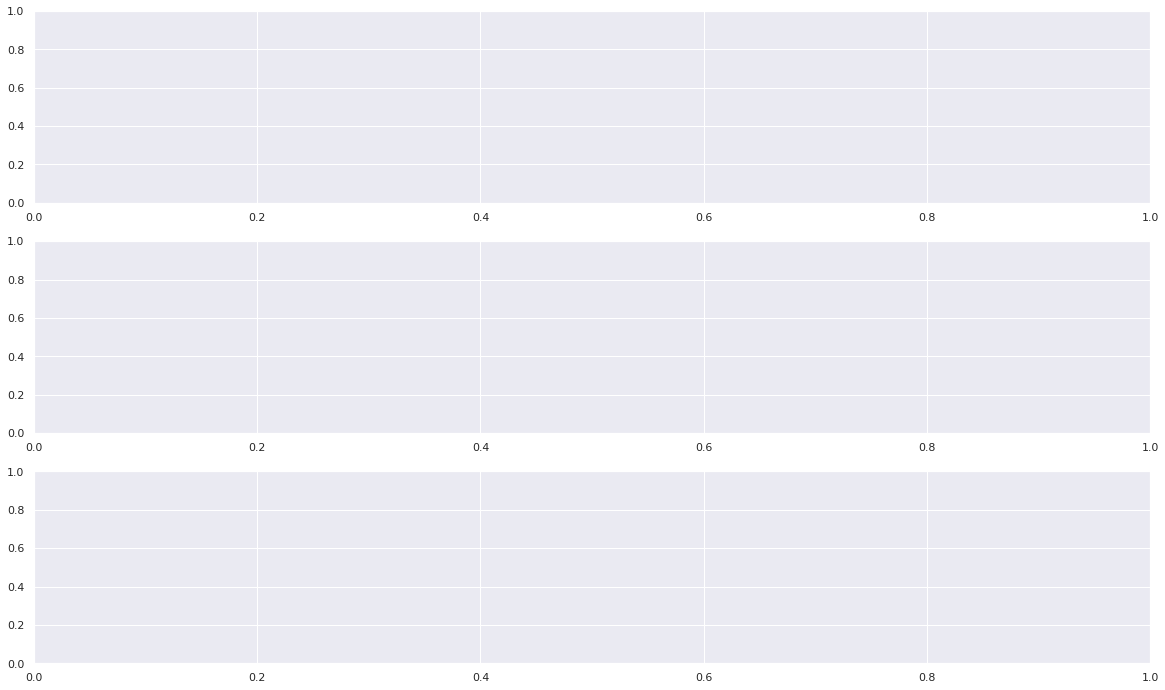

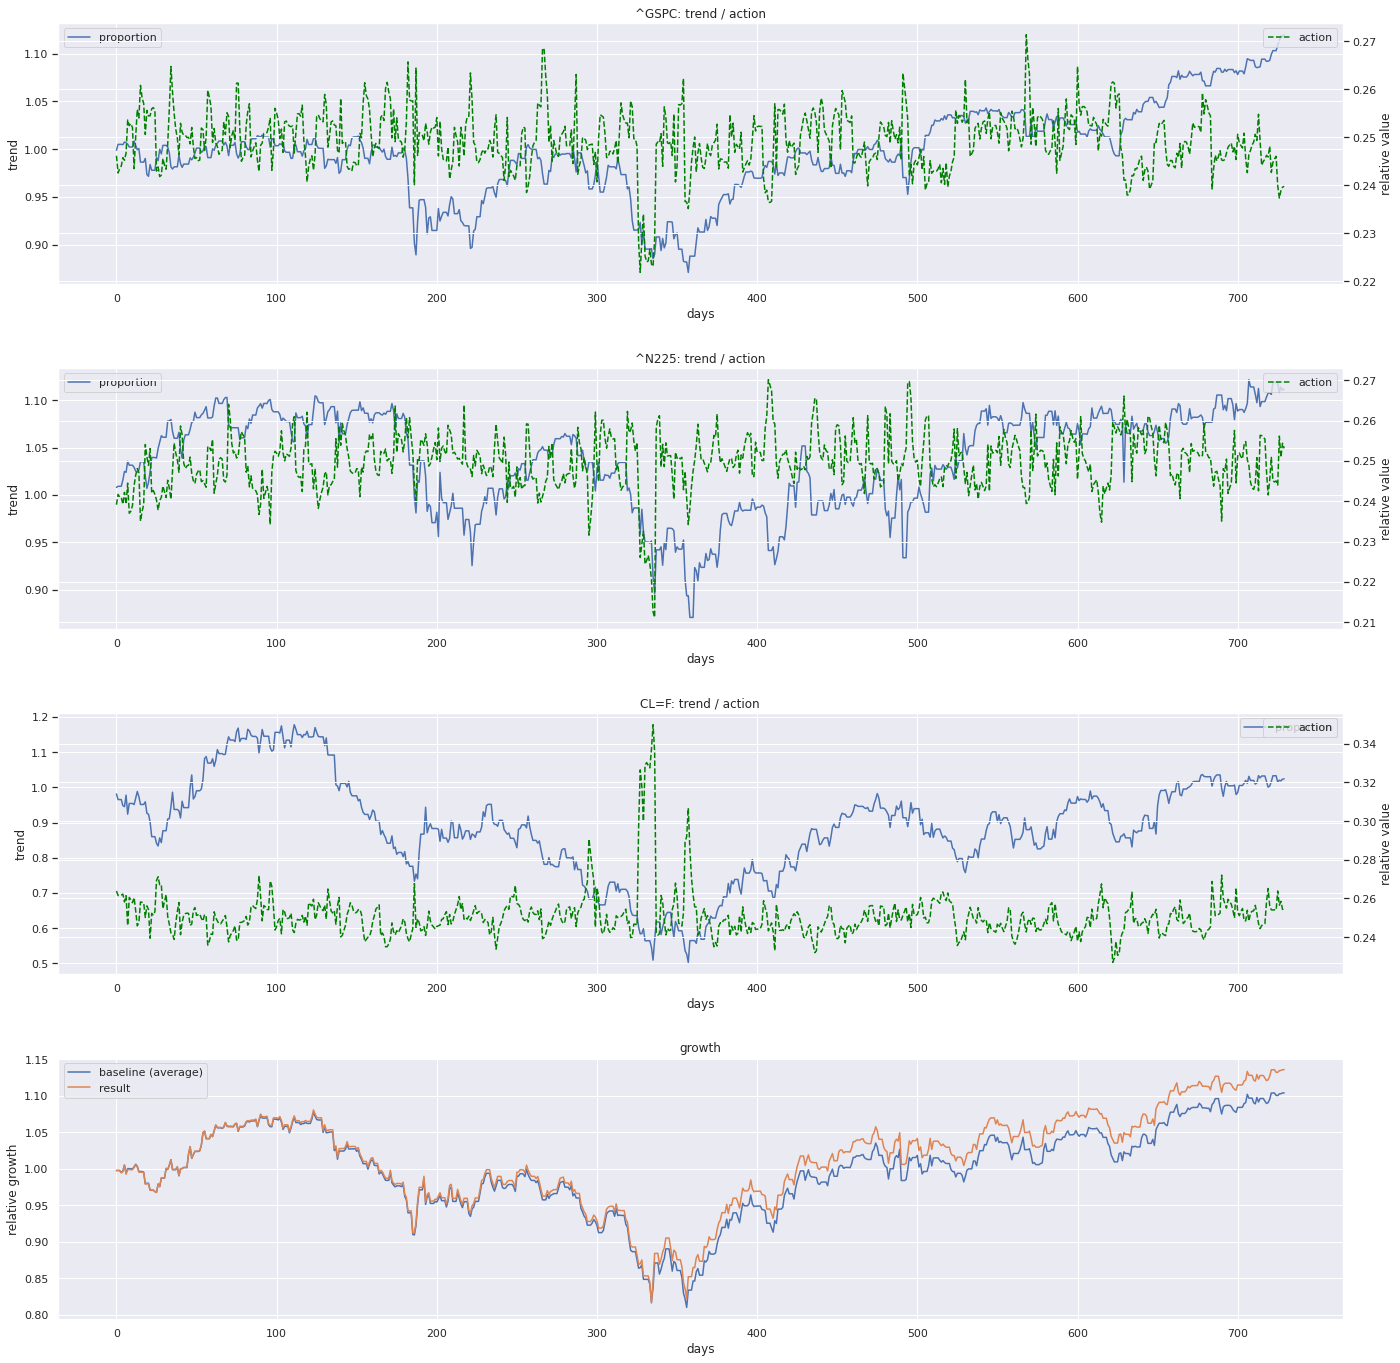

average growth:	1.1040348610345059
final growth:	1.1359253847635369
win/lose: 1 / 0
saveing episode-0 network


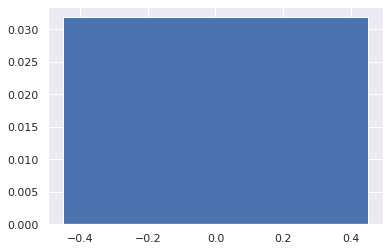

average diff: 0.031890523729031006


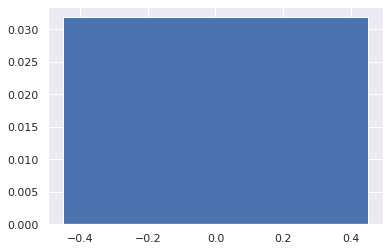

In [30]:
agent.run_test()